In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde #Para distribucion estadistica de los datos en histograma
import scipy.stats as stats #para qqnorm y qqline o histograma Normal Q-Q plot
import statsmodels.api as sm #para el periodo de retorno

# 1. CARGA DEL FICHERO DE DATOS
file_path = "./DatosCaudalesBesos.csv"  # Cambia esto por la ruta de tu archivo si es diferente
TotalDat = pd.read_csv(file_path, encoding='latin1')

# 2. Inspección de los datos
print(TotalDat.info())     # Estructura de los datos
print(TotalDat.head())     # Ver las primeras filas
print(TotalDat.columns)    # Ver los nombres de las variables

# 3. Modificación de los tipos de datos y creación de nuevas variables
TotalDat['Estacio'] = TotalDat['Estacio'].astype('category')  # Convertir 'Estacio' a categoría
print(TotalDat['Estacio'].unique())  # Ver los valores únicos de la variable 'Estacio'

# 3.1 Renombrar con nombres cortos las estaciones de aforo y medida
# Nombres actuales
print(TotalDat['Estacio'].cat.categories)

# Definir los nuevos nombres cortos
nuevos_nombres = {
    'Aforament - Castellar del Vallès': "Castellar",
    'Aforament - Aiguafreda (riu)': "Aiguafreda",
    'Aforament - Montornès del Vallès (el Mogent)': "Montornes",
    'Aforament - Santa Perpètua de Mogoda': "Santa_Perpetua",
    'Aforament - Santa Coloma de Gramenet (riu)': "Santa_Coloma",
    'Aforament - Lliçà de Vall': "Llica_de_Vall",
    'Aforament - Montcada i Reixac (el Ripoll)': "Montcada_Reixac",
    'Aforament - la Garriga': "La_Garriga"
}

# Asignar los nuevos nombres
TotalDat['Estacio'] = TotalDat['Estacio'].replace(nuevos_nombres)
print(TotalDat.head())

# 3.2 Asegurarse de que la columna 'Dia' esté en formato de fecha
TotalDat['Fecha'] = pd.to_datetime(TotalDat['Dia'], format="%m/%d/%Y")

# Extraer el año correctamente ahora que la columna 'Fecha' está en el formato correcto
TotalDat['Year'] = TotalDat['Fecha'].dt.year

# Verificar si se creó la columna 'Year'
print(TotalDat.head())

# 3.3 Creación de nuevas variables (mes, año)
TotalDat['Mes'] = TotalDat['Fecha'].dt.month  # Extraer el mes
TotalDat['Year'] = TotalDat['Fecha'].dt.year  # Extraer el año

# 3.4 Mostrar las primeras filas para revisar las nuevas variables
print(TotalDat.head())

# 4. Cuántos datos tiene cada estación
print(TotalDat['Estacio'].value_counts())

# 5 Detección y eliminación de datos duplicados
DF_Montornes = TotalDat[TotalDat['Estacio'] == "Montornes"]

# Ordenar el dataframe por la columna 'Fecha'
DF_Montornes = DF_Montornes.sort_values(by='Fecha')
print(DF_Montornes.head())

# Eliminar las filas duplicadas
TotalDat = TotalDat.drop_duplicates()

# ORDENAR LAS ESTACIONES en el orden deseado
estaciones_ordenadas = ['Llica_de_Vall', 'Santa_Perpetua', 'Montornes', 
                        'Aiguafreda', 'La_Garriga', 'Montcada_Reixac', 
                        'Santa_Coloma', 'Castellar']
TotalDat['Estacio'] = pd.Categorical(TotalDat['Estacio'], categories=estaciones_ordenadas, ordered=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24952 entries, 0 to 24951
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Dia      24952 non-null  object 
 1   Estacio  24952 non-null  object 
 2   Valor    24842 non-null  float64
dtypes: float64(1), object(2)
memory usage: 584.9+ KB
None
         Dia                           Estacio  Valor
0  7/29/2000  Aforament - Castellar del Vallès   2.06
1  7/30/2000  Aforament - Castellar del Vallès   2.00
2  7/31/2000  Aforament - Castellar del Vallès   1.96
3   8/1/2000  Aforament - Castellar del Vallès   1.64
4   8/2/2000  Aforament - Castellar del Vallès   1.52
Index(['Dia', 'Estacio', 'Valor'], dtype='object')
['Aforament - Castellar del Vallès', 'Aforament - Aiguafreda (riu)', 'Aforament - Montornès del Vallès (el Mogent)', 'Aforament - Santa Perpètua de Mogoda', 'Aforament - Santa Coloma de Gramenet (riu)', 'Aforament - Lliçà de Vall', 'Aforament - Montcada i Reixac (el R

In [261]:
# Ver la tabla de frecuencia para la variable 'Estacio'
print(TotalDat['Estacio'].value_counts())

Estacio
Montcada_Reixac    3648
Llica_de_Vall      3646
Santa_Perpetua     3604
Montornes          3047
Santa_Coloma       2692
Castellar          2577
Aiguafreda         1493
La_Garriga         1198
Name: count, dtype: int64


In [262]:
# 6. Contar el número de datos por estación y por año
tabla_contingencia = TotalDat.groupby(['Estacio', 'Year']).size().reset_index(name='Count')

# Crear el gráfico interactivo con Plotly
fig = px.bar(tabla_contingencia, x='Year', y='Count', color='Estacio', 
             title="Número de datos para cada estación por año", 
             labels={"Count": "Número de Datos", "Year": "Año", "Estacio": "Estación"},
             barmode='group',  # Puedes usar 'stack' para barras apiladas o 'group' para barras agrupadas
             text='Count', hover_name="Estacio")

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Año",
    yaxis_title="Número de Datos",
    legend_title="Estaciones",
    bargap=0.2,
    hovermode="x unified"
)

# Mostrar el gráfico interactivo
fig.show()

In [263]:
# 1. Calcular el caudal medio anual para cada estación por año
caudal_medio_anual = TotalDat.groupby(['Estacio', 'Year']).agg({'Valor': 'mean'}).reset_index()

# 2. Crear el gráfico de barras interactivo con Plotly
fig = px.bar(caudal_medio_anual, x='Year', y='Valor', color='Estacio', 
             title="Caudal Medio Anual por Estación", 
             labels={"Valor": "Caudal Medio (m³/s)", "Year": "Año", "Estacio": "Estación"},
             barmode='group',  # Puedes cambiar a 'stack' si prefieres barras apiladas
             text='Valor', hover_name="Estacio")

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Año",
    yaxis_title="Caudal Medio Anual (m³/s)",
    legend_title="Estaciones",
    bargap=0.15,  # Espacio entre las barras
    hovermode="x unified"
)

# Mostrar el gráfico interactivo
fig.show()

In [264]:
# 5. Crear el gráfico de bigotes (boxplot) con Plotly
fig = px.box(TotalDat, x='Estacio', y='Valor', 
             title="Distribución de Caudales por Estación", 
             labels={"Valor": "Caudal (m³/s)", "Estacio": "Estación"},
             points="all")  # 'points="all"' añade todos los puntos atípicos en el gráfico

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Estación",
    yaxis_title="Caudal (m³/s)",
    boxmode='group',  # Agrupar las cajas por estación
)

# Mostrar el gráfico interactivo
fig.show()

<Figure size 1000x600 with 0 Axes>

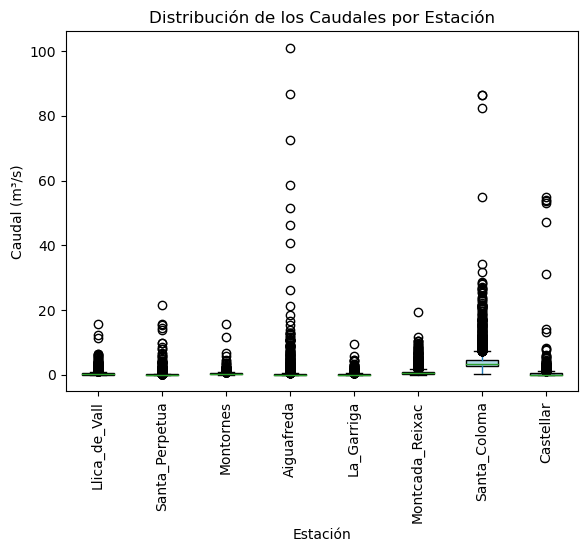

<Figure size 1000x600 with 0 Axes>

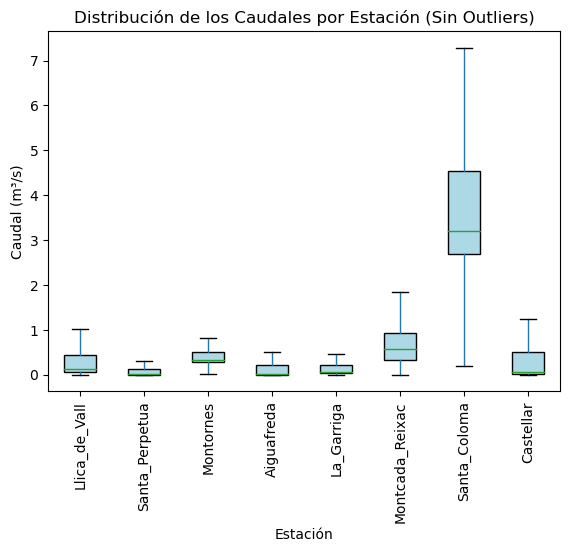

In [265]:
# Calcular la desviación estándar (variabilidad) por estación
variabilidad = TotalDat.groupby('Estacio')['Valor'].std()

# Graficar la distribución de los caudales por estación (Boxplot con outliers)
plt.figure(figsize=(10, 6))
TotalDat.boxplot(column='Valor', by='Estacio', grid=False, showfliers=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Distribución de los Caudales por Estación")
plt.suptitle("")
plt.xlabel("Estación")
plt.xticks(rotation=90)
plt.ylabel("Caudal (m³/s)")
plt.show()

# Graficar la distribución de los caudales por estación (Boxplot sin outliers)
plt.figure(figsize=(10, 6))
TotalDat.boxplot(column='Valor', by='Estacio', grid=False, showfliers=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Distribución de los Caudales por Estación (Sin Outliers)")
plt.suptitle("")
plt.xlabel("Estación")
plt.xticks(rotation=90)
plt.ylabel("Caudal (m³/s)")
plt.show()


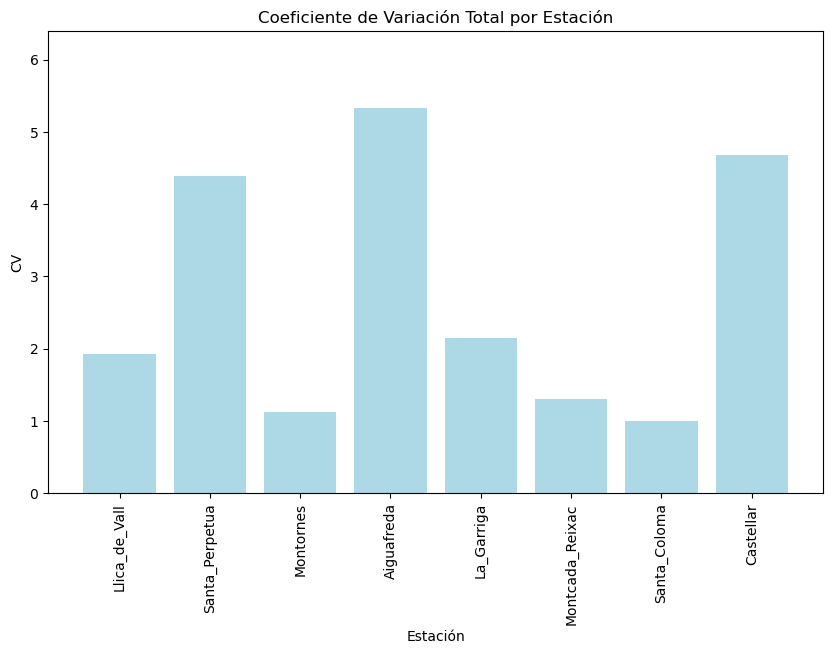

In [266]:
# Definir la función para el coeficiente de variación (CV)
def calc_cv(x):
    return x.std() / x.mean()

# Calcular el coeficiente de variación por estación
cv = TotalDat.groupby('Estacio')['Valor'].apply(calc_cv).reset_index(name='CV')

# Graficar el coeficiente de variación
plt.figure(figsize=(10, 6))
plt.bar(cv['Estacio'], cv['CV'], color="lightblue")
plt.title("Coeficiente de Variación Total por Estación")
plt.xlabel("Estación")
plt.ylabel("CV")
plt.xticks(rotation=90)
plt.ylim(0, max(cv['CV']) * 1.2)  # Ajustar el rango Y para visualizar mejor
plt.show()


<Figure size 1000x600 with 0 Axes>

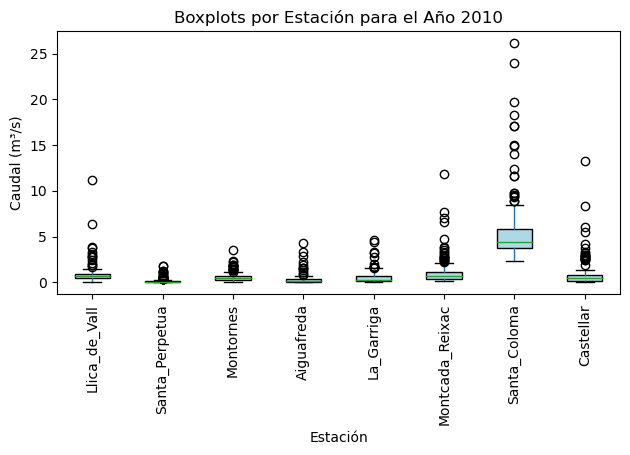

In [267]:
# 2. Crear un subconjunto para el año 2010
datos_Year_2010 = TotalDat[TotalDat['Year'] == 2010]

# 3. Crear un gráfico de boxplots para cada estación en el año 2010
plt.figure(figsize=(10, 6))

# Graficar el boxplot para cada estación
datos_Year_2010.boxplot(column='Valor', by='Estacio', grid=False, showfliers=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))

# Añadir título y etiquetas
plt.title("Boxplots por Estación para el Año 2010")
plt.suptitle('')  # Eliminar el título automático generado por matplotlib
plt.xlabel("Estación")
plt.ylabel("Caudal (m³/s)")
plt.xticks(rotation=90)  # Rotar los nombres de las estaciones si son largos
plt.tight_layout()

# Mostrar el gráfico
plt.show()



In [268]:
# 2. Crear un subconjunto para el año 2010
datos_Year_2010 = TotalDat[TotalDat['Year'] == 2010]

# 3. Crear un gráfico de boxplots para cada estación en el año 2010 usando Plotly
fig = px.box(datos_Year_2010, x='Estacio', y='Valor', 
             title='Boxplots por Estación para el Año 2010',
             labels={'Estacio': 'Estación', 'Valor': 'Caudal (m³/s)'},
             points='all'  # Mostrar todos los puntos atípicos (outliers)
            )

# Mostrar la gráfica interactiva
fig.show()

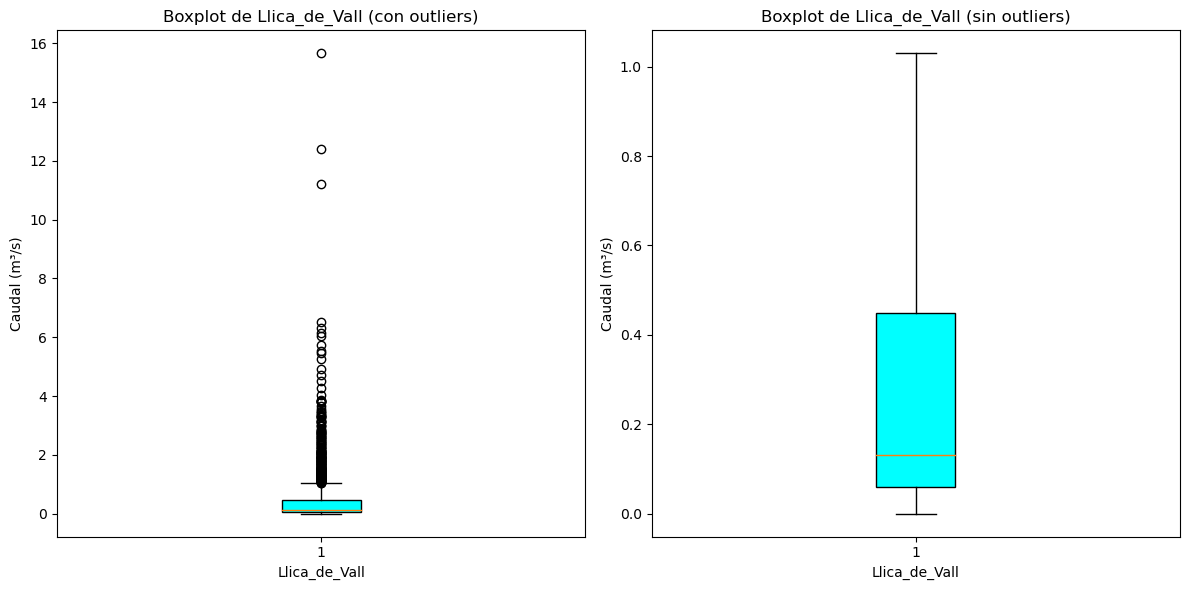

In [269]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Dibujar dos gráficos de boxplot, uno con outliers y otro sin outliers
plt.figure(figsize=(12, 6))

# Subplot 1: Con valores atípicos (outliers)
plt.subplot(1, 2, 1)
plt.boxplot(DF_St['Valor'], patch_artist=True, boxprops=dict(facecolor='cyan'))
plt.title(f"Boxplot de {nombreST} (con outliers)")
plt.xlabel(nombreST)
plt.ylabel("Caudal (m³/s)")

# Subplot 2: Sin valores atípicos (outliers)
plt.subplot(1, 2, 2)
plt.boxplot(DF_St['Valor'], patch_artist=True, boxprops=dict(facecolor='cyan'), showfliers=False)
plt.title(f"Boxplot de {nombreST} (sin outliers)")
plt.xlabel(nombreST)
plt.ylabel("Caudal (m³/s)")

# Ajustar el diseño para que no se sobrepongan los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

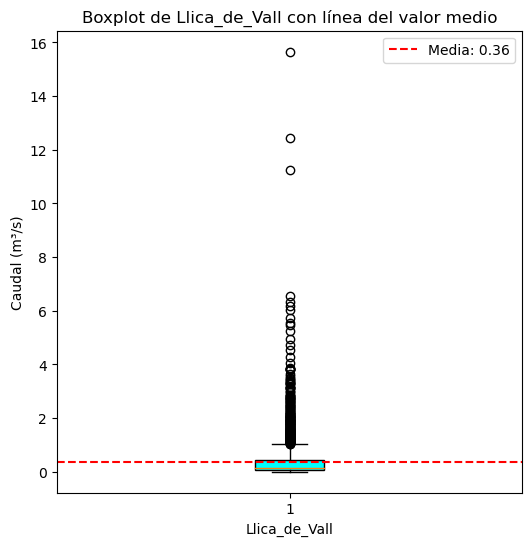

In [270]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Calcular el valor medio del caudal para esa estación, ignorando valores nulos
media_valor = DF_St['Valor'].mean(skipna=True)

# 4. Dibujar el boxplot y añadir la línea del valor medio
plt.figure(figsize=(6, 6))

# Boxplot con valores atípicos
plt.boxplot(DF_St['Valor'].dropna(), patch_artist=True, boxprops=dict(facecolor='cyan'))  # Ignorar NaNs para el boxplot

# Añadir el título y etiquetas
plt.title(f"Boxplot de {nombreST} con línea del valor medio")
plt.xlabel(nombreST)
plt.ylabel("Caudal (m³/s)")

# Añadir una línea horizontal que indica el valor medio
plt.axhline(y=media_valor, color='red', linestyle='--', label=f'Media: {media_valor:.2f}')

# Mostrar la leyenda para la línea del valor medio
plt.legend()

# Mostrar el gráfico
plt.show()

In [271]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Crear un boxplot con Plotly
fig = go.Figure()

# Añadir el boxplot
fig.add_trace(go.Box(
    y=DF_St['Valor'],
    name=nombreST,
    boxmean=False,  # No mostrar la línea de la media automáticamente
    #marker_color='cyan'
))

# Añadir el título y etiquetas
fig.update_layout(
    title=f"Boxplot de {nombreST}",
    xaxis_title=nombreST,
    yaxis_title="Caudal (m³/s)"
)

# Mostrar el gráfico interactivo
fig.show()

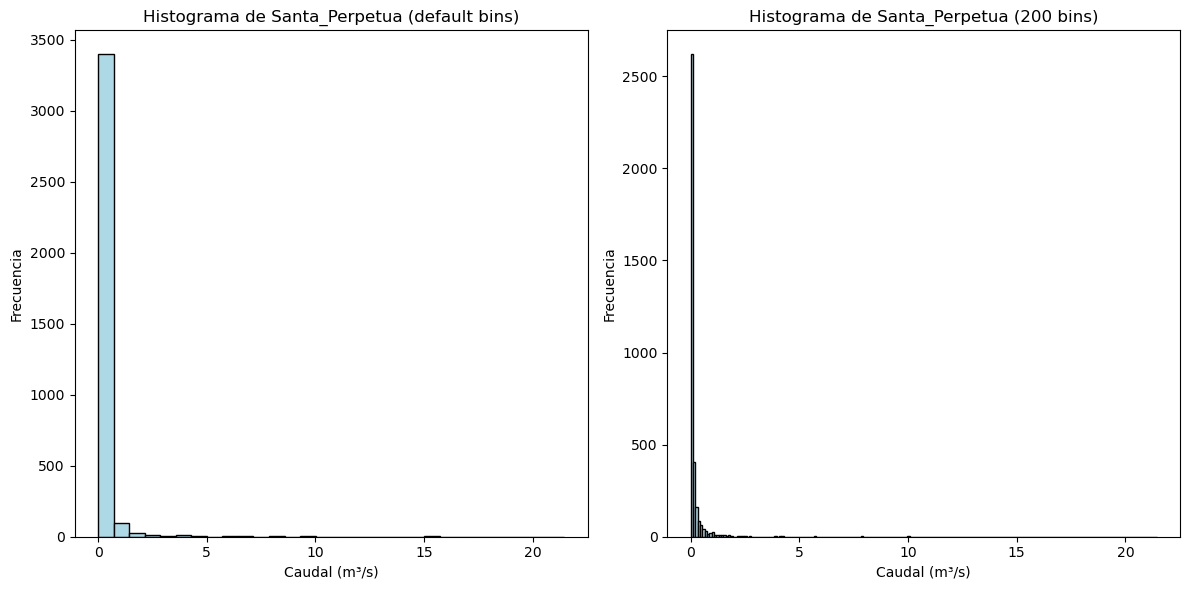

In [272]:
# Estacio
# Montcada_Reixac    3648
# Llica_de_Vall      3646
# Santa_Perpetua     3604
# Montornes          3047
# Santa_Coloma       2692
# Castellar          2577
# Aiguafreda         1493
# La_Garriga         1198

# 2. Seleccionar la estación
nombreST = "Santa_Perpetua"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Dibujar dos histogramas para observar la distribución de los datos
plt.figure(figsize=(12, 6))

# Subplot 1: Histograma con configuración predeterminada
plt.subplot(1, 2, 1)
plt.hist(DF_St['Valor'].dropna(), bins=30, color='lightblue', edgecolor='black')
plt.title(f"Histograma de {nombreST} (default bins)")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Frecuencia")

# Subplot 2: Histograma con 200 divisiones (bins)
plt.subplot(1, 2, 2)
plt.hist(DF_St['Valor'].dropna(), bins=200, color='lightblue', edgecolor='black')
plt.title(f"Histograma de {nombreST} (200 bins)")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Frecuencia")

# Ajustar el diseño para que los gráficos no se superpongan
plt.tight_layout()

# Mostrar los gráficos
plt.show()

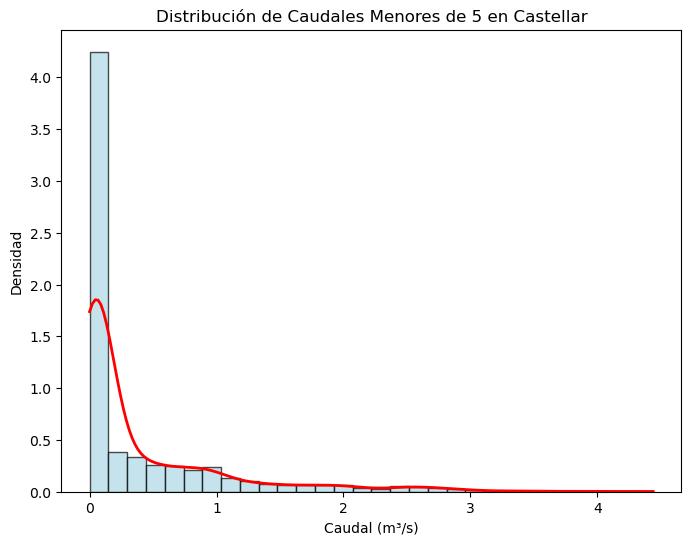

In [273]:
# 2. Seleccionar la estación
nombreST = "Castellar"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Recortar los valores menores a 5 y eliminar los NaNs
St1_nout = DF_St['Valor'][(DF_St['Valor'] < 5) & (DF_St['Valor'].notna())]

# 4. Dibujar el histograma y la curva de densidad
plt.figure(figsize=(8, 6))

# Histograma con probabilidad (densidad) en lugar de frecuencia
plt.hist(St1_nout, bins=30, density=True, color='lightblue', edgecolor='black', alpha=0.7)

# Calcular la curva de densidad utilizando gaussian_kde de scipy
density = gaussian_kde(St1_nout)
x_vals = np.linspace(min(St1_nout), max(St1_nout), 200)
density_vals = density(x_vals)

# Añadir la curva de densidad al histograma
plt.plot(x_vals, density_vals, color='red', lw=2)

# Añadir etiquetas y título
plt.title(f"Distribución de Caudales Menores de 5 en {nombreST}")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Densidad")

# Mostrar el gráfico
plt.show()

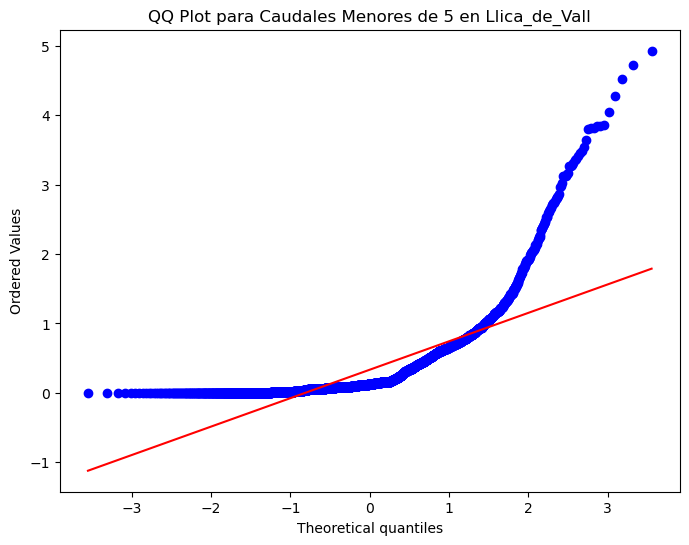

In [274]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Recortar los valores menores a 5 y eliminar los NaNs
St1_nout = DF_St['Valor'][(DF_St['Valor'] < 5) & (DF_St['Valor'].notna())]

# 4. Crear el gráfico QQ plot para comprobar la normalidad
plt.figure(figsize=(8, 6))

# Graficar el QQ plot
stats.probplot(St1_nout, dist="norm", plot=plt)

# Añadir título
plt.title(f"QQ Plot para Caudales Menores de 5 en {nombreST}")

# Mostrar el gráfico
plt.show()

Kolmogorov-Smirnov Test: D = 0.5753595555507774, p-value = 0.0
Shapiro-Wilk Test: W = nan, p-value = 1.0


c:\Users\sarao\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log

c:\Users\sarao\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2699: RuntimeWarning:

invalid value encountered in subtract



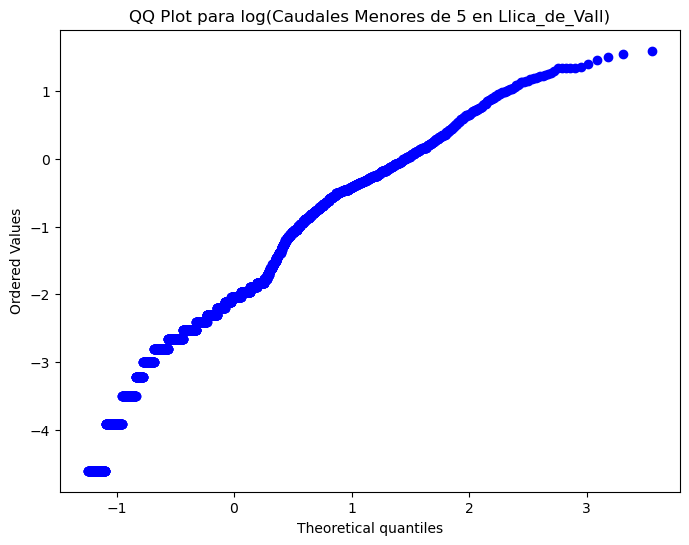

In [275]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Recortar los valores menores a 5 y eliminar los NaNs
St1_nout = DF_St['Valor'][(DF_St['Valor'] < 5) & (DF_St['Valor'].notna())]

# 4. Transformar los valores a logaritmo
log_St1_nout = np.log(St1_nout)

# 5. Kolmogorov-Smirnov test para normalidad
ks_stat, ks_p_value = stats.kstest(log_St1_nout, 'norm')

print(f"Kolmogorov-Smirnov Test: D = {ks_stat}, p-value = {ks_p_value}")

# 6. Test de Shapiro-Wilk para normalidad
shapiro_stat, shapiro_p_value = stats.shapiro(log_St1_nout)

print(f"Shapiro-Wilk Test: W = {shapiro_stat}, p-value = {shapiro_p_value}")

# 7. QQ plot para ver la distribución logarítmica
plt.figure(figsize=(8, 6))
stats.probplot(log_St1_nout, dist="norm", plot=plt)
plt.title(f"QQ Plot para log(Caudales Menores de 5 en {nombreST})")
plt.show()

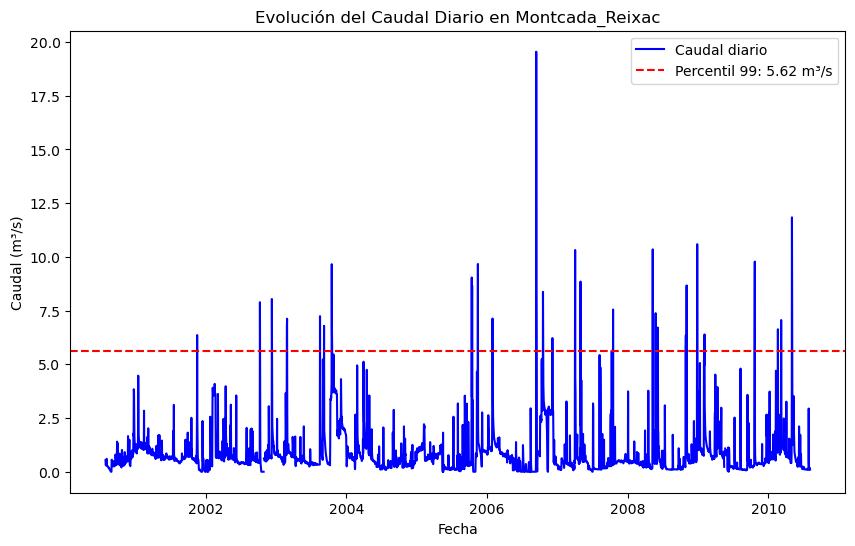

In [276]:
# 2. Seleccionar la estación "Montcada_Reixac"
nombreST = "Montcada_Reixac"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Ordenar los datos por fecha
DF_St = DF_St.sort_values(by='Fecha')

# 4. Dibujar el gráfico de la evolución del caudal diario
plt.figure(figsize=(10, 6))
plt.plot(DF_St['Fecha'], DF_St['Valor'], color='blue', linestyle='-', label='Caudal diario')

# 5. Calcular el percentil 99 del caudal
q99 = np.percentile(DF_St['Valor'].dropna(), 99)

# Añadir una línea horizontal en el percentil 99
plt.axhline(y=q99, color='red', linestyle='--', label=f'Percentil 99: {q99:.2f} m³/s')

# Añadir títulos y etiquetas
plt.title(f"Evolución del Caudal Diario en {nombreST}")
plt.xlabel("Fecha")
plt.ylabel("Caudal (m³/s)")

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

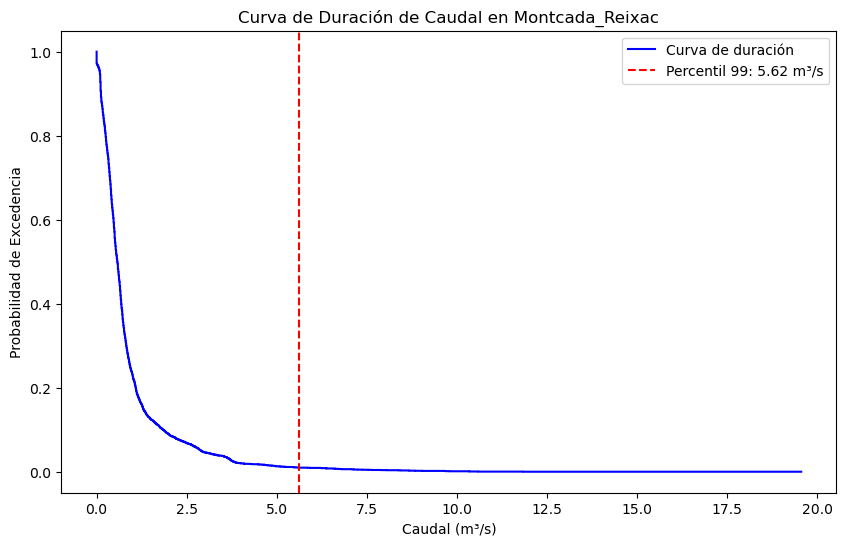

In [277]:
# 2. Seleccionar la estación "Montcada_Reixac"
nombreST = "Montcada_Reixac"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Eliminar los valores faltantes (NaN) en la columna 'Valor'
DF_St = DF_St.dropna(subset=['Valor'])

# 4. Ordenar los valores de caudal en orden descendente
sorted_caudal = DF_St['Valor'].sort_values(ascending=False).reset_index(drop=True)

# 5. Calcular la probabilidad de excedencia
n = len(sorted_caudal)
probabilidad_excedencia = np.arange(1, n+1) / n

# 6. Calcular el percentil 99 del caudal
q99 = np.percentile(sorted_caudal, 99)

# 7. Graficar la curva de duración de caudal
plt.figure(figsize=(10, 6))

# Gráfico de la curva de duración
plt.step(sorted_caudal, probabilidad_excedencia, where='post', color='blue', label='Curva de duración')

# Añadir una línea vertical en el percentil 99
plt.axvline(x=q99, color='red', linestyle='--', label=f'Percentil 99: {q99:.2f} m³/s')

# Añadir títulos y etiquetas
plt.title(f"Curva de Duración de Caudal en {nombreST}")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Probabilidad de Excedencia")

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

El periodo de retorno para un caudal de 5 m³/s es aproximadamente 75.79 días.


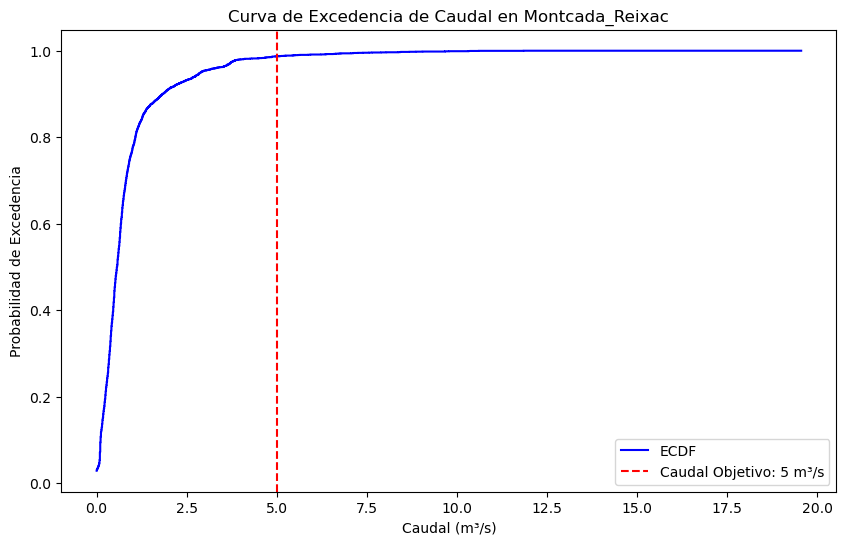

In [278]:
# 2. Seleccionar la estación "Montcada_Reixac"
nombreST = "Montcada_Reixac"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Eliminar los valores faltantes (NaN) en la columna 'Valor'
DF_St = DF_St.dropna(subset=['Valor'])

# 4. Ordenar los valores de caudal en orden descendente
sorted_caudal = DF_St['Valor'].sort_values(ascending=False).reset_index(drop=True)

# 5. Crear la función ECDF usando statsmodels
ecdf = sm.distributions.ECDF(sorted_caudal)

# 6. Definir el caudal objetivo para el cual queremos calcular el periodo de retorno
caudal_objetivo = 5  # Caudal objetivo en m³/s

# 7. Calcular la probabilidad de excedencia para el caudal objetivo
# La probabilidad de excedencia es 1 - ECDF(caudal_objetivo)
probabilidad_excedencia_objetivo = 1 - ecdf(caudal_objetivo)

# 8. Calcular el periodo de retorno en días
if probabilidad_excedencia_objetivo > 0:
    periodo_retorno = 1 / probabilidad_excedencia_objetivo
else:
    periodo_retorno = np.inf  # Si no hay excedencia, el periodo de retorno es infinito

# Imprimir el periodo de retorno
print(f"El periodo de retorno para un caudal de {caudal_objetivo} m³/s es aproximadamente {periodo_retorno:.2f} días.")

# 9. Graficar la curva ECDF
plt.figure(figsize=(10, 6))
plt.step(sorted_caudal, ecdf(sorted_caudal), where='post', color='blue', label='ECDF')

# Añadir línea vertical para el caudal objetivo
plt.axvline(x=caudal_objetivo, color='red', linestyle='--', label=f'Caudal Objetivo: {caudal_objetivo} m³/s')

# Añadir títulos y etiquetas
plt.title(f"Curva de Excedencia de Caudal en {nombreST}")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Probabilidad de Excedencia")

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [280]:
import pandas as pd
import plotly.express as px

# Asegurarse de que la columna 'Fecha' es de tipo datetime
TotalDat['Fecha'] = pd.to_datetime(TotalDat['Fecha'])

# 1. Extraer el año y el mes de la columna 'Fecha'
TotalDat['Year'] = TotalDat['Fecha'].dt.year
TotalDat['Month'] = TotalDat['Fecha'].dt.month

# 2. Calcular el caudal medio mensual para cada estación por mes y año
caudal_medio_mensual = TotalDat.groupby(['Estacio', 'Year', 'Month']).agg({'Valor': 'mean'}).reset_index()

# 3. Crear una nueva columna 'YearMonth' para combinar el año y el mes
caudal_medio_mensual['YearMonth'] = pd.to_datetime(caudal_medio_mensual[['Year', 'Month']].assign(Day=1))

# 4. Crear el gráfico de barras interactivo con Plotly
fig = px.bar(caudal_medio_mensual, x='YearMonth', y='Valor', color='Estacio',
             title="Caudal Medio Mensual por Estación", 
             labels={"Valor": "Caudal Medio (m³/s)", "YearMonth": "Fecha", "Estacio": "Estación"},
             barmode='group',  # Puedes cambiar a 'stack' si prefieres barras apiladas
             text='Valor', hover_name="Estacio")

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Fecha",
    yaxis_title="Caudal Medio Mensual (m³/s)",
    legend_title="Estaciones",
    bargap=0.15,  # Espacio entre las barras
    hovermode="x unified"
)

# Mostrar el gráfico interactivo
fig.show()



In [290]:
import pandas as pd
import plotly.express as px

# 1. Seleccionar una estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()  # Usar .copy() para evitar la advertencia

# 2. Extraer el año y el mes de la columna 'Fecha'
DF_St.loc[:, 'Year'] = DF_St['Fecha'].dt.year  # Usar .loc[] para evitar la advertencia
DF_St.loc[:, 'Month'] = DF_St['Fecha'].dt.month

# 3. Calcular el caudal medio mensual para esa estación por mes y año
caudal_medio_mensual = DF_St.groupby(['Year', 'Month']).agg({'Valor': 'mean'}).reset_index()

# 4. Crear una nueva columna 'YearMonth' para combinar el año y el mes
caudal_medio_mensual['YearMonth'] = pd.to_datetime(caudal_medio_mensual[['Year', 'Month']].assign(Day=1))

# 5. Crear el gráfico de líneas interactivo con Plotly para la estación seleccionada
fig = px.line(caudal_medio_mensual, x='YearMonth', y='Valor', 
              title=f"Evolución del Caudal Medio Mensual en {nombreST}", 
              labels={"Valor": "Caudal Medio Mensual (m³/s)", "YearMonth": "Fecha"},
              #text='Valor'
              )

# 6. Ajustar el diseño del gráfico para mostrar los valores con mayor precisión
fig.update_layout(
    yaxis=dict(tickformat=".4f"),  # Ajustar la precisión del eje Y
    xaxis_title="Fecha",
    yaxis_title="Caudal Medio Mensual (m³/s)",
    hovermode="x unified"
)

# 7. Mostrar el gráfico interactivo
fig.show()
